In [1]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
  COLAB = True
  from google.colab import userdata
  os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from dotenv import load_dotenv
  COLAB = False
  load_dotenv()
print(f"COLAB={COLAB}")

COLAB=False


In [2]:
if COLAB:
  !pip install datasets evaluate transformers[torch] -q

In [3]:
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor
import numpy as np
import evaluate
import torch
import huggingface_hub
from tqdm import tqdm


In [4]:
HF_MODEL_PATH =  "laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K"
PROCESSOR_PATH = "laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K"
TARGET_LABEL = "continent"

EVAL_EXPORT_DIR = "evals/" + HF_MODEL_PATH.split("/")[-1] + '_zeroshot'
print(EVAL_EXPORT_DIR)

evals/CLIP-ViT-L-14-DataComp.XL-s13B-b90K_zeroshot


In [5]:
CUDA_AVAILABLE=torch.cuda.is_available()
print(f"CUDA={CUDA_AVAILABLE}")
device = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"count={torch.cuda.device_count()}")
print(f"current={torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA=True
count=1
current=NVIDIA GeForce RTX 4070


In [6]:
import os
if not os.path.exists(EVAL_EXPORT_DIR):
    os.makedirs(EVAL_EXPORT_DIR)

In [7]:
# huggingface_hub.login(token=os.environ.get('HF_TOKEN'))
ds = load_dataset("jrheiner/kerger_1024_v2")
im2gps = load_dataset("jrheiner/im2gps")
im2gps2k = load_dataset("jrheiner/im2gps2k")

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'continent', 'country', 'altitude', 'compass_angle', 'captured_at', 'camera_type', 'exif_orientation', 'day_night', 'percentage_dark_pixels', 'height', 'width', 'longitude', 'latitude'],
        num_rows: 63960
    })
    test: Dataset({
        features: ['image', 'image_id', 'continent', 'country', 'altitude', 'compass_angle', 'captured_at', 'camera_type', 'exif_orientation', 'day_night', 'percentage_dark_pixels', 'height', 'width', 'longitude', 'latitude'],
        num_rows: 7020
    })
    validation: Dataset({
        features: ['image', 'image_id', 'continent', 'country', 'altitude', 'compass_angle', 'captured_at', 'camera_type', 'exif_orientation', 'day_night', 'percentage_dark_pixels', 'height', 'width', 'longitude', 'latitude'],
        num_rows: 7020
    })
})

In [9]:
im2gps

DatasetDict({
    train: Dataset({
        features: ['image', 'continent', 'country', 'im2gps_category', 'latitude', 'longitude'],
        num_rows: 237
    })
})

In [10]:
im2gps2k

DatasetDict({
    train: Dataset({
        features: ['image', 'continent', 'country', 'latitude', 'longitude'],
        num_rows: 2000
    })
})

In [11]:
def get_mapping(dataset_split, label):
    labels = dataset_split.features[label].names
    label2id, id2label = dict(), dict()
    for i, label in enumerate(labels):
        label2id[label] = i
        id2label[i] = label
    return id2label, label2id, labels

id2label, label2id, labels = get_mapping(ds["train"], TARGET_LABEL)
labels

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

North America, 43.727438021453 -70.407347974542


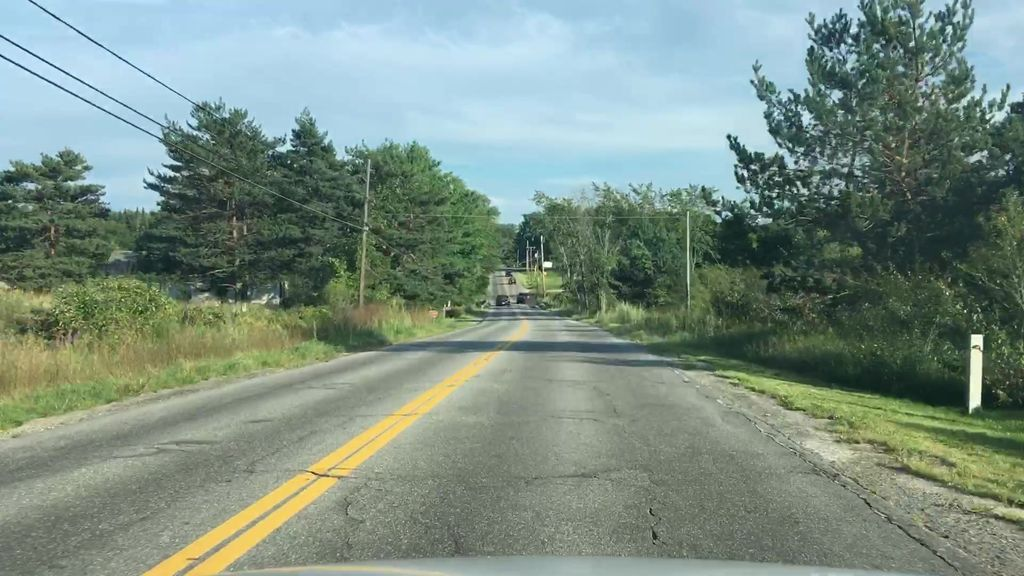

In [12]:
print(f"{id2label[ds['train'][0][TARGET_LABEL]]}, {ds['train'][0]['latitude']} {ds['train'][0]['longitude']}")
ds["train"][0]["image"]

In [13]:
model = CLIPModel.from_pretrained(HF_MODEL_PATH)
processor = CLIPProcessor.from_pretrained(HF_MODEL_PATH)
print(model.config)

config.json:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/repos/57/8d/578ddc43cf2804098ab8806beffdc2c2b91b0e5fe4e88c534bb0b996f11c78e5/cbae707ef72c3d2748f3c9482e9ca8645d8bbd915d59a86e4f11107c9b341068?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1721377063&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTM3NzA2M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy81Ny84ZC81NzhkZGM0M2NmMjgwNDA5OGFiODgwNmJlZmZkYzJjMmI5MWIwZTVmZTRlODhjNTM0YmIwYjk5NmYxMWM3OGU1L2NiYWU3MDdlZjcyYzNkMjc0OGYzYzk0ODJlOWNhODY0NWQ4YmJkOTE1ZDU5YTg2ZTRmMTExMDdjOWIzNDEwNjg%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=bDVEis5d02o97u8Z4uEh37can1B39KYnrwfoA67%7E5Lvb5UG8fgyGXWh74Rkr-saPiiCgZqJDPDl7vH3m5VR3JYcxKQXkMqZCdhCQ2j9pBWW3G9Pv6zx0OrH8AYpujQ14Y4Cvu0zcfLlVTA2YYVvAF-gNx3bwbvhiLkw

pytorch_model.bin:  99%|#########9| 1.70G/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

CLIPConfig {
  "_name_or_path": "laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 768,
  "text_config": {
    "bos_token_id": 0,
    "eos_token_id": 2,
    "hidden_act": "gelu",
    "hidden_size": 768,
    "intermediate_size": 3072,
    "model_type": "clip_text_model",
    "num_attention_heads": 12
  },
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "vision_config": {
    "hidden_act": "gelu",
    "hidden_size": 1024,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14
  }
}



In [14]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [15]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

metrics = [accuracy, f1, precision, recall]

In [16]:
def prediction_pipeline(dataset, batch_size, ds_size, text_prompts):
    i_ds = dataset.to_iterable_dataset()

    pred_ids = []
    gt_ids = []

    pbar = tqdm(enumerate(i_ds.iter(batch_size=batch_size)), total=int(ds_size/batch_size)+1)
    for idx, batch in pbar:
        inputs = processor(text=text_prompts, images=batch["image"], return_tensors='pt', padding=True)
        batch_gt_ids = batch[TARGET_LABEL]
        gt_ids.extend(batch_gt_ids)

        inputs = inputs.to(device)


        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=-1)
            batch_pred_ids = probs.argmax(axis=-1).to("cpu")

        pred_ids.extend([x.item() for x in batch_pred_ids])
        
        pbar.set_postfix_str(f"Accuracy: {accuracy.compute(predictions=pred_ids, references=gt_ids)['accuracy']:.4f}")
        
        # if idx == 5:
        #     break

    return pred_ids

In [17]:
# text_prompts = [f"{geo}" for geo in labels]
text_prompts = [f"A photo from {geo}." for geo in labels]
# text_prompts = [f"A photo taken in {geo}." for geo in labels]
# text_prompts = [f"A StreetView photo in {geo}" for geo in labels]
print(labels)
print(text_prompts)

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
['A photo from Africa.', 'A photo from Asia.', 'A photo from Europe.', 'A photo from North America.', 'A photo from Oceania.', 'A photo from South America.']


In [18]:
results = {
    "validation": {},
    "test": {},
    "im2gps": {},
    "im2gps2k": {}
}

In [19]:
validation_preds = prediction_pipeline(ds["validation"], 512, ds["validation"].num_rows, text_prompts)
for metric in metrics:
    if metric.name != "accuracy":
        results["validation"][metric.name] = metric.compute(references=ds["validation"][TARGET_LABEL], predictions=validation_preds, average="weighted")[metric.name]
    else: 
        results["validation"][metric.name] = metric.compute(references=ds["validation"][TARGET_LABEL], predictions=validation_preds)[metric.name]

results

100%|██████████| 14/14 [01:36<00:00,  6.90s/it, Accuracy: 0.6151]


{'validation': {'accuracy': 0.6150997150997151,
  'f1': 0.5817065498161693,
  'precision': 0.6915077051430377,
  'recall': 0.6150997150997151},
 'test': {},
 'im2gps': {},
 'im2gps2k': {}}

In [156]:
np.save(f"{EVAL_EXPORT_DIR}/validation_preds", validation_preds)

In [19]:
test_preds = prediction_pipeline(ds["test"], 32, ds["test"].num_rows, text_prompts)
for metric in metrics:
    if metric.name != "accuracy":
        results["test"][metric.name] = metric.compute(references=ds["test"][TARGET_LABEL], predictions=test_preds, average="weighted")[metric.name]
    else: 
        results["test"][metric.name] = metric.compute(references=ds["test"][TARGET_LABEL], predictions=test_preds)[metric.name]
print(HF_MODEL_PATH)
results


100%|██████████| 220/220 [02:34<00:00,  1.42it/s, Accuracy: 0.5960]

laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K


{'validation': {},
 'test': {'accuracy': 0.596011396011396,
  'f1': 0.5373488896981677,
  'precision': 0.649635087878525,
  'recall': 0.596011396011396},
 'im2gps': {},
 'im2gps2k': {}}

In [158]:
np.save(f"{EVAL_EXPORT_DIR}/test_preds", test_preds)

               precision    recall  f1-score   support

       Africa       0.62      0.32      0.42      2730
         Asia       0.48      0.23      0.31      2730
       Europe       0.64      0.55      0.59      2730
North America       0.32      0.89      0.47      2730
      Oceania       0.34      0.12      0.17      2730
South America       0.35      0.36      0.35      2730

     accuracy                           0.41     16380
    macro avg       0.46      0.41      0.39     16380
 weighted avg       0.46      0.41      0.39     16380

--------------------


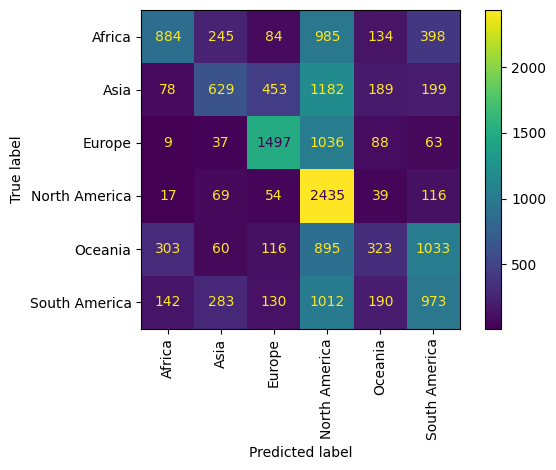

In [159]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(ds["validation"][TARGET_LABEL], validation_preds, target_names=labels))
print("-"*20)
ConfusionMatrixDisplay.from_predictions(ds["validation"][TARGET_LABEL], validation_preds, display_labels=labels, xticks_rotation="vertical")
plt.tight_layout()
plt.savefig(f"{EVAL_EXPORT_DIR}/validation_confusion_matrix.png")
plt.show()

               precision    recall  f1-score   support

       Africa       0.64      0.31      0.41      1170
         Asia       0.50      0.23      0.31      1170
       Europe       0.64      0.53      0.58      1170
North America       0.31      0.88      0.46      1170
      Oceania       0.33      0.12      0.18      1170
South America       0.35      0.35      0.35      1170

     accuracy                           0.40      7020
    macro avg       0.46      0.40      0.38      7020
 weighted avg       0.46      0.40      0.38      7020

--------------------


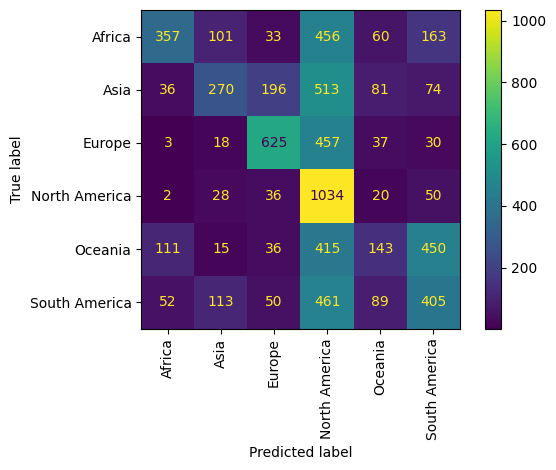

In [160]:
print(classification_report(ds["test"][TARGET_LABEL], test_preds, target_names=labels))
print("-"*20)
ConfusionMatrixDisplay.from_predictions(ds["test"][TARGET_LABEL], test_preds, display_labels=labels, xticks_rotation="vertical")
plt.tight_layout()
plt.savefig(f"{EVAL_EXPORT_DIR}/test_confusion_matrix.png")
plt.show()

In [188]:
im2gps_preds = prediction_pipeline(im2gps["train"], 32, im2gps["train"].num_rows, text_prompts)
for metric in metrics:
    if metric.name != "accuracy":
        results["im2gps"][metric.name] = metric.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds, average="weighted")[metric.name]
    else: 
        results["im2gps"][metric.name] = metric.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds)[metric.name]
results

# im2gps_outputs = pipe(im2gps["train"]["image"])
# im2gps_preds = predictions_processor(im2gps_outputs, label2id)
# results["im2gps_accuracy"] = accuracy.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds["predictions_id"])
# results["im2gps_f1"] = f1.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds["predictions_id"], average="weighted")
# results["im2gps_precision"] = precision.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds["predictions_id"], average="weighted")
# results["im2gps_recall"] = recall.compute(references=im2gps["train"][TARGET_LABEL], predictions=im2gps_preds["predictions_id"], average="weighted")
# results

100%|██████████| 8/8 [00:03<00:00,  2.66it/s, Accuracy: 0.6540]


{'validation': {'accuracy': 0.6158119658119658,
  'f1': 0.6006717467962434,
  'precision': 0.6536718046269999,
  'recall': 0.6158119658119658},
 'test': {},
 'im2gps': {'accuracy': 0.6540084388185654,
  'f1': 0.6921615330223213,
  'precision': 0.792499698157195,
  'recall': 0.6540084388185654},
 'im2gps2k': {}}

In [162]:
np.save(f"{EVAL_EXPORT_DIR}/im2gps_preds", im2gps_preds)

               precision    recall  f1-score   support

       Africa       0.78      0.64      0.70        11
         Asia       0.72      0.66      0.69        50
       Europe       0.77      0.76      0.76        86
North America       0.77      0.51      0.62        70
      Oceania       0.14      0.71      0.23         7
South America       0.29      0.31      0.30        13

     accuracy                           0.63       237
    macro avg       0.58      0.60      0.55       237
 weighted avg       0.71      0.63      0.66       237

--------------------


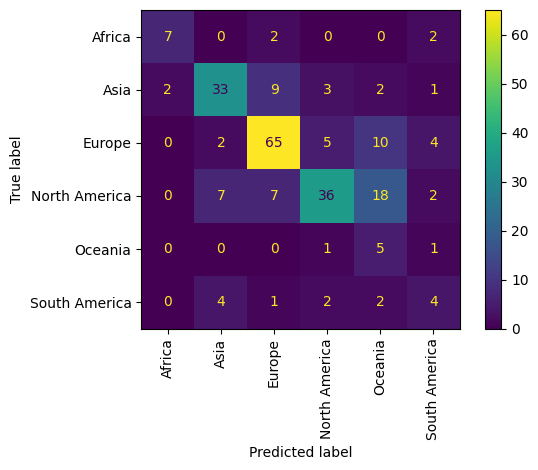

In [163]:
print(classification_report(im2gps["train"][TARGET_LABEL], im2gps_preds, target_names=labels))
print("-"*20)
ConfusionMatrixDisplay.from_predictions(im2gps["train"][TARGET_LABEL], im2gps_preds, display_labels=labels, xticks_rotation="vertical")
plt.tight_layout()
plt.savefig(f"{EVAL_EXPORT_DIR}/im2gps_confusion_matrix.png")
plt.show()

In [164]:
im2gps2k_preds = prediction_pipeline(im2gps2k["train"], 32, im2gps2k["train"].num_rows, text_prompts)
for metric in metrics:
    if metric.name != "accuracy":
        results["im2gps2k"][metric.name] = metric.compute(references=im2gps2k["train"][TARGET_LABEL], predictions=im2gps2k_preds, average="weighted")[metric.name]
    else: 
        results["im2gps2k"][metric.name] = metric.compute(references=im2gps2k["train"][TARGET_LABEL], predictions=im2gps2k_preds)[metric.name]
results

100%|██████████| 63/63 [00:20<00:00,  3.14it/s, Accuracy: 0.5155]


{'validation': {'accuracy': 0.4115384615384615},
 'test': {'accuracy': 0.40370370370370373},
 'im2gps': {'accuracy': 0.6329113924050633},
 'im2gps2k': {'accuracy': 0.5155}}

In [165]:
np.save(f"{EVAL_EXPORT_DIR}/im2gps2k_preds", im2gps2k_preds)

               precision    recall  f1-score   support

       Africa       0.59      0.26      0.36       104
         Asia       0.47      0.63      0.54       357
       Europe       0.60      0.70      0.65       632
North America       0.78      0.37      0.50       724
      Oceania       0.17      0.61      0.27        94
South America       0.20      0.17      0.18        89

     accuracy                           0.52      2000
    macro avg       0.47      0.45      0.42      2000
 weighted avg       0.60      0.52      0.52      2000

--------------------


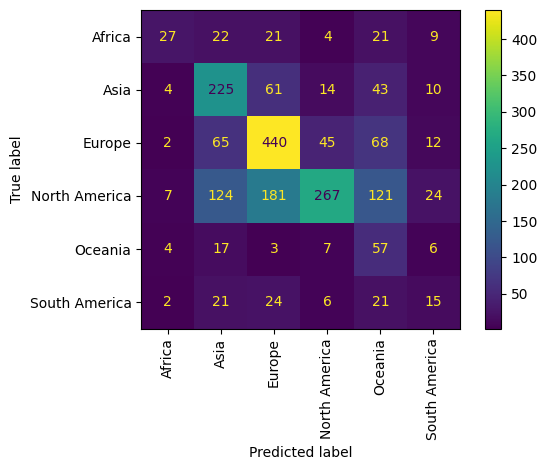

In [166]:
print(classification_report(im2gps2k["train"][TARGET_LABEL], im2gps2k_preds, target_names=labels))
print("-"*20)
ConfusionMatrixDisplay.from_predictions(im2gps2k["train"][TARGET_LABEL], im2gps2k_preds, display_labels=labels, xticks_rotation="vertical")
plt.tight_layout()
plt.savefig(f"{EVAL_EXPORT_DIR}/im2gps2k_confusion_matrix.png")
plt.show()

In [167]:
from datetime import datetime
import json

with open(f"{EVAL_EXPORT_DIR}/results.txt", "a") as f:
    f.write(f"eval of {HF_MODEL_PATH} at {datetime.now()}\n{'-'*50}\n\n")
    f.write(f"Text prompts: {text_prompts}")
    f.write("\n\n")
    f.write(json.dumps(results, indent=2))
    f.write("\n\n")
    f.write("# validation split\n\n")
    f.write(classification_report(ds["validation"][TARGET_LABEL], validation_preds, target_names=labels))
    f.write("\n\n# test split\n\n")
    f.write(classification_report(ds["test"][TARGET_LABEL], test_preds, target_names=labels))
    f.write("\n\n# im2gps split\n\n")
    f.write(classification_report(im2gps["train"][TARGET_LABEL], im2gps_preds, target_names=labels))
    f.write("\n\n# im2gps2k split\n\n")
    f.write(classification_report(im2gps2k["train"][TARGET_LABEL], im2gps2k_preds, target_names=labels))
    f.write("\n\n")
    f.write("#"*50)
    f.write("\n\n")